# Introduction to deep learning in python

In these introductory exercises, we hope to make you familiar with deep learning in Python, specifically the use of lasagne and theano to train and apply convolutional neural networks. Some of the exercises require training of CNNs, which can take a couple of minutes. While you are waiting, I highly recommend having a look at the lasagne documentation and theano tutorials to help you understand what is going on under the hood:

- Lasagne documentation: http://lasagne.readthedocs.org/
- Theano tutorials: http://deeplearning.net/software/theano/tutorial/

For those of you not familiar with IPython notebooks, they are interactive webpages which allow you to write text and intersperse this with executable code. To execute a cell, click the cell and press shift-enter. Keep in mind that you have to execute the cells in order (e.g. if you do not execute the cell with the imports below, the rest of the notebook will not work). Happy exercising!

In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
import cPickle as pickle
import time
import theano
import theano.tensor as T
import lasagne
from math import sqrt, ceil

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## MNIST: building convolutional networks

Our first set of exercises will involve the MNIST dataset, which is a set of 60000 handwritten digits ranging from 0 through 9. We will design a convolutional neural network which, given a patch containing one of these digits, predicts which digit it is. We start of with loading the data from disk and arranging it in numpy arrays.

In [2]:
f = gzip.open(r"/home/user/deep-learning/nfbia15-deep-learning/examples/mnist_cifar/datasets/mnist.pkl.gz", "rb")
data = pickle.load(f)
f.close()

# The MNIST dataset we have here consists of six numpy arrays:
# Inputs (X) and label (y) for the training set, validation set and test set.
X_train, y_train = data[0]
X_val, y_val = data[1]
X_test, y_test = data[2]
X_train = X_train.reshape((-1, 1, 28, 28))
X_val = X_val.reshape((-1, 1, 28, 28))
X_test = X_test.reshape((-1, 1, 28, 28))
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)
y_test = y_test.astype(np.uint8)

No that we have loaded the data, let's visualize it so we know what we are dealing with. The function below takes a block of data containing samples, transforms it into a single image and then displays it using matplotlib.

In [3]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def visualize_data(data, padsize=1, padval=0, cmap="gray", image_size=(10,10)):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=image_size)
    plt.imshow(data, cmap=cmap)
    plt.axis('off')

By repeatedly executing the cell below, you will see 16 differing samples each time.

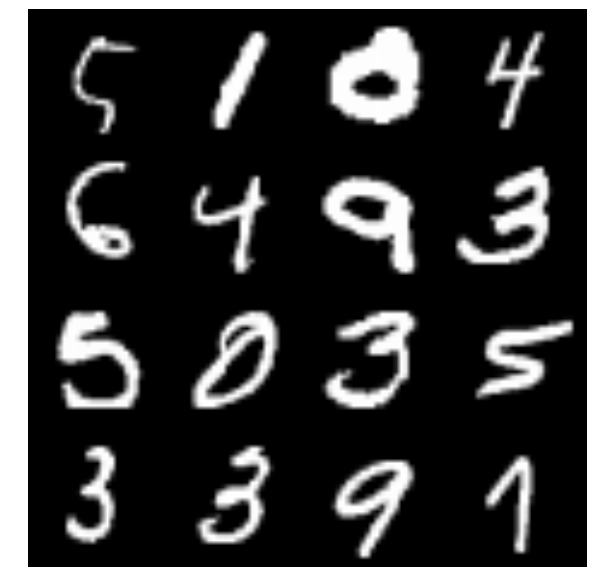

In [4]:
random_incides = np.random.randint(0,X_train.shape[0], 16)
visualize_data(np.squeeze(X_train[random_incides]))

Now that we have the data, let's define a simple classifier. We'll start with simple softmax regression (multi-class extension of logistic regression). We define this classifier using the lasagne and theano packages, which are open-source. Theano is a symbolic math library which is used to build symbolic mathematical expressions. Subsequently, they can be compiled into fast CPU or CUDA binaries. Lasagne is a library built on top of theano which defines some existing structures and expresisons which are used in deep learning (e.g. convolutional layers, cost functions).

In [5]:
# First we define the symbolic input X and the symbolic target y. We want
# to solve the equation y = C(X) where C is a classifier.
inputs = T.tensor4('X')
targets = T.ivector('y')

# Now we start building our classifier:
# Input layer, specifying the expected input shape of the network
# (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
# linking it to the given Theano variable `input_var`, if any:
l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=inputs)

# We'll add the fully-connected output layer, of 10 softmax units (for the
# 10 digit classes (0-9):
l_out = lasagne.layers.DenseLayer(
        l_in, num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

# Simply put, C is now defined as y = (l_out(l_in(X))), where l_in does not
# change the data at all.

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss).
# First we get the prediction from the last layer and then calculate the
# the loss for each sample and take the mean as final loss.
prediction = lasagne.layers.get_output(l_out)
loss = lasagne.objectives.categorical_crossentropy(prediction, targets)
loss = loss.mean()

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD), but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.sgd(loss, params, learning_rate=0.1)

# As a bonus, also create an expression for the classification accuracy:
acc = T.mean(T.eq(T.argmax(prediction, axis=1), targets),
            dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([inputs, targets], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([inputs, targets], [prediction, loss, acc])

Now that we have our network training and classification functions, let's train the network. The below function defines a for-loop over a numpy-array and allows us to extract mini-batches from the training data.

In [6]:
# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

And then we use the for-loop to train the network on the training data and assess its accuracy on the validation data set. We track the cost and accuracy accross epochs (pass over the training data) with lists.

In [7]:
# The number of epochs specifies the number of passes over the whole training data
num_epochs = 100
curves = {'train_loss': [], 'val_loss': [], 'val_acc': []}
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        preds, err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    curves['train_loss'].append(train_err / train_batches)
    curves['val_loss'].append(val_err / val_batches)
    curves['val_acc'].append(val_acc / val_batches)

Epoch 1 of 100 took 0.228s
  training loss:		0.979946
  validation loss:		0.574552
  validation accuracy:		87.28 %
Epoch 2 of 100 took 0.147s
  training loss:		0.552803
  validation loss:		0.456345
  validation accuracy:		88.75 %
Epoch 3 of 100 took 0.166s
  training loss:		0.473860
  validation loss:		0.409126
  validation accuracy:		89.32 %
Epoch 4 of 100 took 0.190s
  training loss:		0.435156
  validation loss:		0.382943
  validation accuracy:		89.90 %
Epoch 5 of 100 took 0.181s
  training loss:		0.411004
  validation loss:		0.366081
  validation accuracy:		90.13 %
Epoch 6 of 100 took 0.179s
  training loss:		0.394150
  validation loss:		0.354343
  validation accuracy:		90.51 %
Epoch 7 of 100 took 0.165s
  training loss:		0.381661
  validation loss:		0.343914
  validation accuracy:		90.69 %
Epoch 8 of 100 took 0.167s
  training loss:		0.371529
  validation loss:		0.336965
  validation accuracy:		90.92 %
Epoch 9 of 100 took 0.211s
  training loss:		0.363516
  validation loss:		0.3305

Now let's see how our learning curves (cost over epochs) look. Learning curves can tell us a lot about network training behavior. You expect learning curves to show rapid decline at the .start, after which they stabilize and slowly converge to an asymptotic value. We also plot the accuracy over time. 

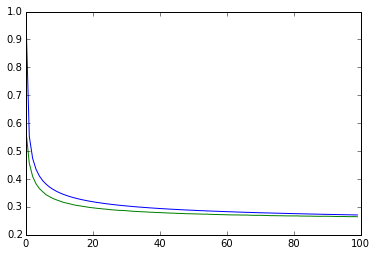

In [8]:
plt.plot(zip(curves['train_loss'], curves['val_loss']));

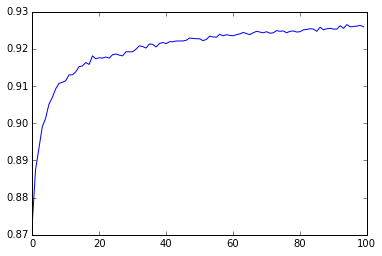

In [9]:
plt.plot(curves['val_acc']);

Although looking at the learning curves can tell us how the network learns, it does not show us what kind of mistakes it makes and if what it is learning is meaningfull. Below we provide a function which can plot the labels and predictions for a set of samples. This allows you to see where the network makes mistakes. Are they logical mistakes (e.g. confusing a 1 and a 7) or really way out (confusing a 1 with 0)? This tells you whether the features the network is learning are sensible and tied to the recognition task.

In [10]:
def visualize_predictions(data, labels, label_to_name={}):
    preds, err, acc = val_fn(data, labels)
    pred_labels = np.argmax(preds, axis=1)
    correct = np.equal(labels, pred_labels)
    per_row = int(0.5 + sqrt(data.shape[0]))
    nr_rows = int(ceil(data.shape[0] / float(per_row)))
    fig, grid = plt.subplots(nr_rows, per_row, figsize=(10,10))  
    cmap = None
    if data.shape[1] == 1:
        cmap="gray"    
    for r in range(nr_rows):
        for c in range(per_row):
            if (r*per_row + c < data.shape[0]):
                grid[r,c].imshow(np.squeeze(data[r*per_row + c].transpose(1,2,0)), cmap=cmap)
                grid[r,c].set_xticklabels([])
                grid[r,c].set_xticklabels([])
                grid[r,c].set_yticklabels([])
                if label_to_name:
                    grid[r,c].set_xlabel("Label = " + str(label_to_name[labels[r*per_row + c]]) + "\nPredicted = " + str(label_to_name[pred_labels[r*per_row + c]]))
                else:
                    grid[r,c].set_xlabel("Label = " + str(labels[r*per_row + c]) + "\nPredicted = " + str(pred_labels[r*per_row + c]))
                for tic in grid[r][c].xaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                for tic in grid[r][c].yaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                color = "green"
                if correct[r*per_row + c] == False:
                    color = "red"
                grid[r,c].spines['bottom'].set_color(color)
                grid[r,c].spines['bottom'].set_linewidth(2)
                grid[r,c].spines['top'].set_color(color)
                grid[r,c].spines['top'].set_linewidth(2)
                grid[r,c].spines['left'].set_color(color)
                grid[r,c].spines['left'].set_linewidth(2)
                grid[r,c].spines['right'].set_color(color)
                grid[r,c].spines['right'].set_linewidth(2)
            else :
                grid[r,c].axis('off')
    plt.tight_layout()

By repeatedly running the cell below you get a new set of examples.

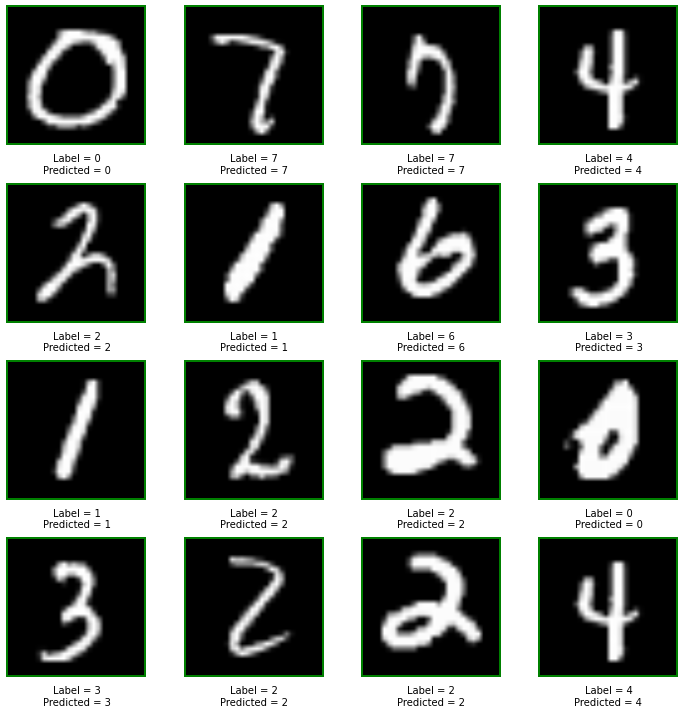

In [11]:
random_incides = np.random.randint(0,X_val.shape[0], 16)
visualize_predictions(X_val[random_incides], y_val[random_incides])

Another visualization strategy that can be meaningful is visualizing the weights of the layers. Remember that in the first layer, each node is a linear combination of the weight vector with the pixel values of the input (which are then fed through the non-linearity). To visualize what a node represents you want to maximally active that node (i.e. get the highest possible output). This happens when the input image has high values at the pixels which correspond to a high weight. This can be represented by visualizing the weights of the node as an image. This is what we do in the cell below. Visualizing weights in this way allows us to see if the weights are smooth and representing interesting structures.

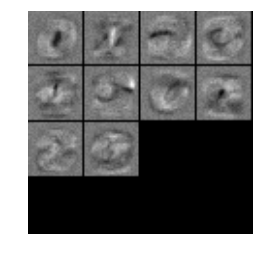

In [12]:
parameters = lasagne.layers.get_all_param_values(l_out)
weights = parameters[0]
weights = weights.reshape(28,28,10).transpose(2,0,1)
visualize_data(weights, image_size=(4,4))

### Exercise 1
Below you find the code to define a convolutional layer and a pooling layer in Lasagne. Try to add a convolutional and pooling layer to the network implemented above, in between the input and the output layer. Try to compare the learning curves to the network using only softmax regression. How do the weights look? Do you improve performance?

In [ ]:
# Convolutional layer with 32 kernels of size 5x5. Strided and padded
# convolutions are supported as well; see the docstring.
lasagne.layers.Conv2DLayer(
        "REPLACE ME WITH THE CORRECT INPUT", num_filters=8, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())

In [ ]:
lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

### Exercise 2
Below you find the code to define a fully connected layer in Lasagne. Often convolutional networks are considered to have a feature extraction part (the convolutional and pooling layers) and a classification part (the fully connected layers). Currently we are using a linear softmax classifier in the last layer. By adding an extra fully-connected layer between the last convolutional and pooling layer we can create a non-linear clasifier. Try to add this dense layer. Investigate performance and network characteristics.

In [ ]:
lasagne.layers.DenseLayer(
        "REPLACE ME WITH THE CORRECT INPUT",
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform()
)

## CIFAR-10: data augmentation and dropout

In the following exercises we will focus on the application of dropout (regularization) and data augmentation to improve the results of our convolutional neural network. We will use the CIFAR-10 data set to evaluate the performance. CIFAR-10 is a dataset of natural images depicting 10 different classes like dogs, cats, trucks and airplanes. Images are quite small (32x32px) and in color. The CIFAR-10 dataset is significantely more challenging than the MNIST data sets. As such it is good example set to show you how overfitting looks and how to combat overfitting with regularization. In this exercise we will look at two regularization strategies: dropout and data-augmentation.

First, lets load the data set and visualize some samples. Can you label all the images correctly?

In [14]:
f = open(r"/home/user/deep-learning/nfbia15-deep-learning/examples/mnist_cifar/datasets/cifar10/data_batch_1", "rb")
cifar_batch_1 = pickle.load(f)
f.close()
train_X_cifar = (cifar_batch_1['data'].reshape(-1, 3, 32, 32) / 255.).astype("float32")
train_y_cifar = np.array(cifar_batch_1['labels'], dtype='ubyte')
for i in range(1,4):
    f = open(r"/home/user/deep-learning/nfbia15-deep-learning/examples/mnist_cifar/datasets/cifar10/data_batch_1", "rb")
    cifar_batch = pickle.load(f)
    f.close()
    np.append(train_X_cifar, (cifar_batch['data'].reshape(-1, 3, 32, 32) / 255.).astype("float32"), axis=0)
    np.append(train_y_cifar, np.array(cifar_batch['labels'], dtype='ubyte'), axis=0)
f = open(r"/home/user/deep-learning/nfbia15-deep-learning/examples/mnist_cifar/datasets/cifar10/data_batch_5", "rb")
cifar_batch_5 = pickle.load(f)
f.close()
val_X_cifar = (cifar_batch_5['data'].reshape(-1, 3, 32, 32) / 255.).astype("float32")
val_y_cifar = np.array(cifar_batch_5['labels'], dtype='ubyte')
f = open(r"/home/user/deep-learning/nfbia15-deep-learning/examples/mnist_cifar/datasets/cifar10/batches.meta", "rb")
cifar_dict = pickle.load(f)
label_to_names = {k:v for k, v in zip(range(10), cifar_dict['label_names'])}
f.close()

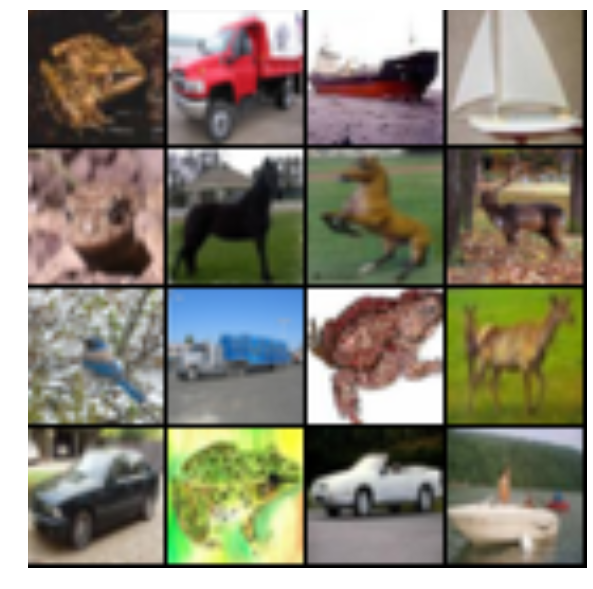

In [15]:
random_incides = np.random.randint(0,train_X_cifar.shape[0], 16)
visualize_data(train_X_cifar[random_incides].transpose(0,2,3,1))

Now let's create a convolutional neural network. Our pre-setup network contains two convolutional and two dense layers. Although we would need a much more complex network to achieve state-of-the-art results, for the current exercise this is enough. Build the network and train it for around 20 epochs.

In [16]:
# We define the network in exactly the same way as we did before
inputs = T.tensor4('X')
targets = T.ivector('y')

# Our input layer is different now because we have color images.
network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                    input_var=inputs)
network = lasagne.layers.Conv2DLayer(
            network, num_filters=16, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(3, 3))

network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

network = lasagne.layers.DenseLayer(
            network,
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform()
)

# We'll add the fully-connected output layer, of 10 softmax units (for the
# 10 classes (e.g. dog, cat, etc.):
network = lasagne.layers.DenseLayer(
            network, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)


# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss).
# First we get the prediction from the last layer and then calculate the
# the loss for each sample and take the mean as final loss.
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, targets)
loss = loss.mean()

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD), but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.sgd(loss, params, learning_rate=0.1)


test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, targets)
test_loss = loss.mean()
acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), targets),
            dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([inputs, targets], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([inputs, targets], [test_prediction, test_loss, acc])

In [17]:
# The number of epochs specifies the number of passes over the whole training data
num_epochs = 20
curves = {'train_loss': [], 'val_loss': [], 'val_acc': []}
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_X_cifar, train_y_cifar, 32, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(val_X_cifar, val_y_cifar, 500, shuffle=False):
        inputs, targets = batch
        preds, err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    curves['train_loss'].append(train_err / train_batches)
    curves['val_loss'].append(val_err / val_batches)
    curves['val_acc'].append(val_acc / val_batches)

Epoch 1 of 20 took 21.678s
  training loss:		2.178296
  validation loss:		2.016875
  validation accuracy:		27.79 %
Epoch 2 of 20 took 22.126s
  training loss:		1.885451
  validation loss:		1.893516
  validation accuracy:		28.51 %
Epoch 3 of 20 took 21.733s
  training loss:		1.696712
  validation loss:		1.650303
  validation accuracy:		39.76 %
Epoch 4 of 20 took 21.970s
  training loss:		1.588889
  validation loss:		1.558296
  validation accuracy:		42.96 %
Epoch 5 of 20 took 21.617s
  training loss:		1.491906
  validation loss:		1.485974
  validation accuracy:		46.55 %
Epoch 6 of 20 took 21.653s
  training loss:		1.452092
  validation loss:		1.486172
  validation accuracy:		47.08 %
Epoch 7 of 20 took 21.624s
  training loss:		1.354783
  validation loss:		1.552777
  validation accuracy:		44.73 %
Epoch 8 of 20 took 21.519s
  training loss:		1.292186
  validation loss:		1.481616
  validation accuracy:		48.05 %
Epoch 9 of 20 took 21.465s
  training loss:		1.245814
  validation loss:		1.4786

Looking at the learning curves (execute the cell below), you can see the training loss continues to improve, while the validation loss does not. This is a typical case of overfitting, the extra performance obtained in training does not generalize to an unseen set of images. If we look at the validation accuracy, this also become quite apparent.

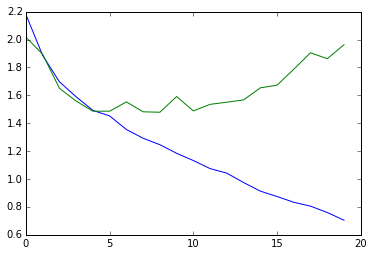

In [18]:
plt.plot(zip(curves['train_loss'], curves['val_loss']));

0.49420000000000003

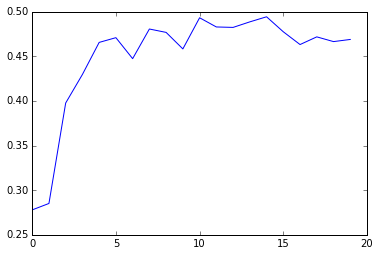

In [19]:
plt.plot(curves['val_acc']);
max(curves['val_acc'])

Again, we can visualize some of the mistakes made by the network.

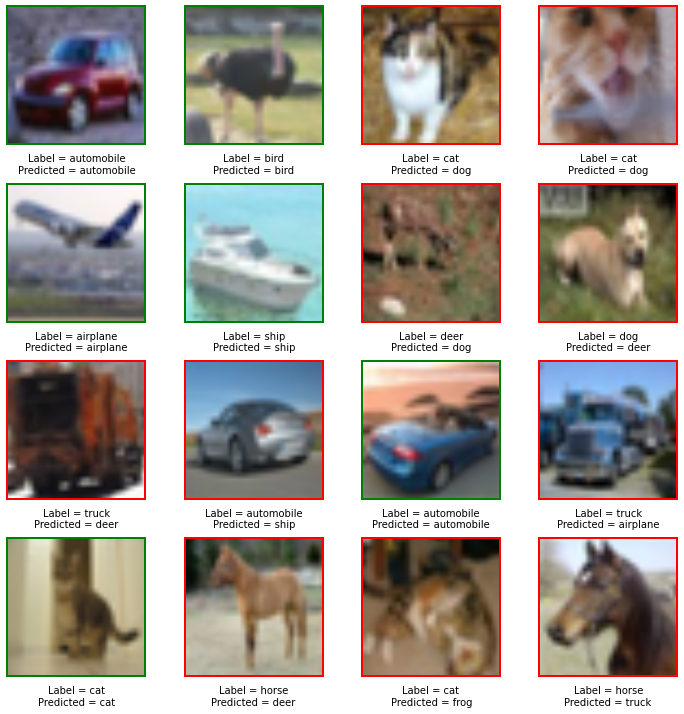

In [20]:
random_incides = np.random.randint(0,val_X_cifar.shape[0], 16)
visualize_predictions(val_X_cifar[random_incides], val_y_cifar[random_incides], label_to_names)

And of course the weights. You may notice that although some weights show structures (i.e. they have learned a features), other weights are 'flat', indicating that they have not learned anything meaningful.

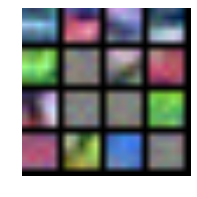

In [21]:
parameters = lasagne.layers.get_all_param_values(network, trainable=True)
weights = parameters[0]
weights = weights.transpose(0,2,3,1)
visualize_data(weights, image_size=(3,3))

### Exercise 3

To combat overfitting, several regularization techniques are available, one of which is dropout. Dropout randomly sets network nodes to a value of 0, essentially causing them to not contribute to the classification. This helps because it forces nodes to become independent, removing co-dependent features in the network. Below you find the line of code needed to apply dropout to a layer. You should remove the "INPUT LAYER" string and replace it with the layer you want to apply dropout to. The second argument specifies the likelihood for any node that it becomes 0. We would recommend trying to apply it to the first dense layer.

Once you have your new network architecture ready, try re-training the network. What happens to the learning curves? And to the validation accuracy?

In [ ]:
lasagne.layers.dropout("INPUT_LAYER", 0.2)

### Exercise 4

The last exercise focuses on another regularization technique, data augmentation. In data augmentation we apply a transformation to the input images to force the network to generalize better. For example, by randomly rotating the input images you force the network to become rotation-invariant, improving its ability to generalize to different poses of the object of interest.

Below you find two functions. Execute the iterate_minibatches_augmented cell and change the iterate_minibatches function in the network training cell to use this function. Then, change augment inputs to perform data augmentation. Your inputs are an array with the shape of (nr_samples, channels, rows, cols). By putting inputs[indices_to_augment] you will obtain a random subset of the samples which you can augment.

As suggested data augmentation strategy, have a look at numpy.rot90 for rotating images and numpy.random.randn for generating noise samples from a Gaussian distribution.

In [165]:
def augment_inputs(inputs):
    indices_to_augment = np.random.choice(range(inputs.shape[0]), inputs.shape[0]//2)
    for ind in indices_to_augment:
        pass
    return inputs

In [164]:
def iterate_minibatches_augmented(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        augmented_inputs = augment_inputs(inputs[excerpt])
        yield augmented_inputs, targets[excerpt]